# RL Training Analysis

This notebook analyzes training and evaluation data from Lambda GPU instances.

## Data Sources
- `../data/runs/*/logs/train_log.jsonl` - Training metrics over time
- `../data/runs/*/logs/rollouts.jsonl` - Rollout data and rewards
- `../data/eval_runs/*/consolidated_metrics.csv` - Evaluation results
- `../data/runs/*/logs/ratios.jsonl` - Policy ratio statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Data directory
data_dir = Path('../data')
runs_dir = data_dir / 'runs'
eval_dir = data_dir / 'eval_runs'
metrics_dir = data_dir / 'metrics'

## 1. Load Training Data

In [ ]:
def load_jsonl(filepath):
    """Load JSONL file into pandas DataFrame"""
    if not filepath.exists():
        print(f"File not found: {filepath}")
        return pd.DataFrame()
    
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return pd.DataFrame(data)

def load_training_run(run_name):
    """Load all data for a specific training run"""
    run_path = runs_dir / run_name
    
    data = {}
    
    # Training log
    train_log_path = run_path / 'logs' / 'train_log.jsonl'
    if train_log_path.exists():
        data['training'] = load_jsonl(train_log_path)
        print(f"Loaded {len(data['training'])} training steps")
    
    # Rollouts
    rollouts_path = run_path / 'logs' / 'rollouts.jsonl'
    if rollouts_path.exists():
        data['rollouts'] = load_jsonl(rollouts_path)
        print(f"Loaded {len(data['rollouts'])} rollout records")
    
    # Ratios
    ratios_path = run_path / 'logs' / 'ratios.jsonl'
    if ratios_path.exists():
        data['ratios'] = load_jsonl(ratios_path)
        print(f"Loaded {len(data['ratios'])} ratio records")
    
    return data

# List available runs
if runs_dir.exists():
    available_runs = [p.name for p in runs_dir.iterdir() if p.is_dir()]
    print(f"Available training runs: {available_runs}")
else:
    print("No data directory found. Please sync data from Lambda first.")
    available_runs = []

## 2. Load Evaluation Data

In [ ]:
def load_evaluation_data(run_name_pattern=None):
    """Load evaluation results"""
    if not eval_dir.exists():
        print("No evaluation data directory found.")
        return pd.DataFrame()
    
    eval_data = []
    
    for eval_run_dir in eval_dir.iterdir():
        if not eval_run_dir.is_dir():
            continue
            
        if run_name_pattern and run_name_pattern not in eval_run_dir.name:
            continue
            
        # Load consolidated metrics
        metrics_file = eval_run_dir / 'consolidated_metrics.csv'
        if metrics_file.exists():
            df = pd.read_csv(metrics_file)
            df['eval_run'] = eval_run_dir.name
            eval_data.append(df)
    
    if eval_data:
        combined = pd.concat(eval_data, ignore_index=True)
        print(f"Loaded evaluation data for {len(eval_data)} runs")
        return combined
    else:
        print("No evaluation data found")
        return pd.DataFrame()

# Load all evaluation data
eval_df = load_evaluation_data()
if not eval_df.empty:
    print(f"Evaluation data shape: {eval_df.shape}")
    print(f"Columns: {eval_df.columns.tolist()}")

## 3. Training Progress Analysis

In [ ]:
# Select a run to analyze
if available_runs:
    run_to_analyze = available_runs[0]  # Change this to analyze different runs
    print(f"Analyzing run: {run_to_analyze}")
    
    # Load the run data
    run_data = load_training_run(run_to_analyze)
    
    # Plot training metrics
    if 'training' in run_data and not run_data['training'].empty:
        train_df = run_data['training']
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Training Progress - {run_to_analyze}', fontsize=16)
        
        # Loss
        if 'loss' in train_df.columns:
            axes[0, 0].plot(train_df['step'], train_df['loss'])
            axes[0, 0].set_title('Training Loss')
            axes[0, 0].set_xlabel('Step')
            axes[0, 0].set_ylabel('Loss')
        
        # Entropy
        if 'entropy' in train_df.columns:
            axes[0, 1].plot(train_df['step'], train_df['entropy'])
            axes[0, 1].set_title('Entropy')
            axes[0, 1].set_xlabel('Step')
            axes[0, 1].set_ylabel('Entropy')
        
        # KL Divergence
        if 'kl' in train_df.columns:
            axes[0, 2].plot(train_df['step'], train_df['kl'])
            axes[0, 2].set_title('KL Divergence')
            axes[0, 2].set_xlabel('Step')
            axes[0, 2].set_ylabel('KL')
        
        # Reward
        if 'r_mean' in train_df.columns:
            axes[1, 0].plot(train_df['step'], train_df['r_mean'])
            axes[1, 0].set_title('Mean Reward')
            axes[1, 0].set_xlabel('Step')
            axes[1, 0].set_ylabel('Reward')
        
        # Tag Correct (accuracy)
        if 'tag_correct' in train_df.columns:
            axes[1, 1].plot(train_df['step'], train_df['tag_correct'])
            axes[1, 1].set_title('Tag Correctness')
            axes[1, 1].set_xlabel('Step')
            axes[1, 1].set_ylabel('Accuracy')
        
        # Ratio statistics
        if 'ratio_mean' in train_df.columns:
            axes[1, 2].plot(train_df['step'], train_df['ratio_mean'], label='Mean')
            if 'ratio_clip_frac' in train_df.columns:
                axes[1, 2].plot(train_df['step'], train_df['ratio_clip_frac'], label='Clip Fraction')
            axes[1, 2].set_title('Policy Ratios')
            axes[1, 2].set_xlabel('Step')
            axes[1, 2].set_ylabel('Ratio')
            axes[1, 2].legend()
        
        plt.tight_layout()
        plt.show()
        
        # Show recent stats
        print("\nRecent training statistics:")
        print(train_df.tail())
else:
    print("No training runs available for analysis")

## 4. Evaluation Results Analysis

In [ ]:
if not eval_df.empty:
    # Plot evaluation metrics across steps
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Evaluation Results Across Training Steps', fontsize=16)
    
    # Group by run for multiple runs
    for eval_run in eval_df['eval_run'].unique():
        run_eval = eval_df[eval_df['eval_run'] == eval_run]
        
        # Pass rate
        if 'pass_rate' in run_eval.columns:
            axes[0, 0].plot(run_eval['step'], run_eval['pass_rate'], 'o-', label=eval_run)
    
    axes[0, 0].set_title('Pass Rate')
    axes[0, 0].set_xlabel('Training Step')
    axes[0, 0].set_ylabel('Pass Rate')
    axes[0, 0].legend()
    
    # Response length
    for eval_run in eval_df['eval_run'].unique():
        run_eval = eval_df[eval_df['eval_run'] == eval_run]
        if 'response_len_mean' in run_eval.columns:
            axes[0, 1].plot(run_eval['step'], run_eval['response_len_mean'], 'o-', label=eval_run)
    
    axes[0, 1].set_title('Mean Response Length')
    axes[0, 1].set_xlabel('Training Step')
    axes[0, 1].set_ylabel('Length')
    
    # Entropy
    for eval_run in eval_df['eval_run'].unique():
        run_eval = eval_df[eval_df['eval_run'] == eval_run]
        if 'entropy_mean' in run_eval.columns:
            axes[1, 0].plot(run_eval['step'], run_eval['entropy_mean'], 'o-', label=eval_run)
    
    axes[1, 0].set_title('Mean Entropy')
    axes[1, 0].set_xlabel('Training Step')
    axes[1, 0].set_ylabel('Entropy')
    
    # Show data table
    axes[1, 1].axis('off')
    if len(eval_df) > 0:
        # Create summary table
        summary_cols = ['step', 'pass_rate', 'response_len_mean', 'entropy_mean']
        available_cols = [col for col in summary_cols if col in eval_df.columns]
        
        if available_cols:
            summary_data = eval_df[available_cols].round(3)
            table = axes[1, 1].table(cellText=summary_data.values,
                                   colLabels=summary_data.columns,
                                   cellLoc='center',
                                   loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            axes[1, 1].set_title('Evaluation Summary')
    
    plt.tight_layout()
    plt.show()
    
    print("\nEvaluation data summary:")
    print(eval_df.describe())
else:
    print("No evaluation data available for analysis")

## 5. Compare Multiple Runs

In [ ]:
# Load multiple runs for comparison
all_training_data = {}

for run_name in available_runs[:3]:  # Analyze up to 3 runs
    run_data = load_training_run(run_name)
    if 'training' in run_data:
        all_training_data[run_name] = run_data['training']

if all_training_data:
    # Compare key metrics across runs
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Comparison Across Runs', fontsize=16)
    
    metrics_to_plot = ['loss', 'entropy', 'r_mean', 'tag_correct']
    titles = ['Loss', 'Entropy', 'Mean Reward', 'Tag Correctness']
    
    for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
        ax = axes[i // 2, i % 2]
        
        for run_name, train_df in all_training_data.items():
            if metric in train_df.columns:
                ax.plot(train_df['step'], train_df[metric], 'o-', label=run_name, alpha=0.7)
        
        ax.set_title(title)
        ax.set_xlabel('Step')
        ax.set_ylabel(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No training data available for comparison")

## 6. Data Export and Custom Analysis

Use this section for custom analysis and exporting processed data.

In [ ]:
# Export processed data for further analysis
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True)

# Combine all training data
if all_training_data:
    combined_training = []
    for run_name, train_df in all_training_data.items():
        train_df = train_df.copy()
        train_df['run_name'] = run_name
        combined_training.append(train_df)
    
    if combined_training:
        combined_df = pd.concat(combined_training, ignore_index=True)
        combined_df.to_csv(output_dir / 'combined_training_data.csv', index=False)
        print(f"Exported combined training data: {combined_df.shape}")

# Export evaluation data
if not eval_df.empty:
    eval_df.to_csv(output_dir / 'combined_evaluation_data.csv', index=False)
    print(f"Exported evaluation data: {eval_df.shape}")

print(f"\nProcessed data saved to: {output_dir}")

In [2]:
# Load the rollouts data from our fresh 4-step run
rollouts_path = Path('../data/runs/run_2025-08-19_05-50-13/logs/rollouts.jsonl')

print(f"Loading rollouts from: {rollouts_path}")
print(f"File exists: {rollouts_path.exists()}")

if rollouts_path.exists():
    # Load JSONL data
    rollouts_data = []
    with open(rollouts_path, 'r') as f:
        for line in f:
            if line.strip():
                rollouts_data.append(json.loads(line))
    
    # Convert to DataFrame
    rollouts_df = pd.DataFrame(rollouts_data)
    print(f"\nLoaded {len(rollouts_df)} rollout records")
    print(f"Columns: {rollouts_df.columns.tolist()}")
    print(f"Steps in data: {sorted(rollouts_df['step_idx'].unique())}")
    
    # Show first few records
    print(f"\nFirst 3 records:")
    print(rollouts_df[['step_idx', 'prompt_id', 'reward', 'tag_correct', 'generation_time_s']].head(3))
else:
    print("Rollouts file not found!")

Loading rollouts from: ..\data\runs\run_2025-08-19_05-50-13\logs\rollouts.jsonl
File exists: True

Loaded 776 rollout records
Columns: ['prompt_id', 'prompt_text', 'gen_text', 'think_len', 'reward', 'tag_correct', 'include_in_batch', 'difficulty_tag', 'token_entropy', 'token_logprob', 'generation_time_s', 'step_idx', 'seq_logprob']
Steps in data: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

First 3 records:
   step_idx   prompt_id  reward  tag_correct  generation_time_s
0         0  3658705608     1.0          1.0                0.0
1         0  3658705608     1.0          1.0                0.0
2         0  3658705608     1.0          1.0                0.0


Mean reward per step:
   step_idx      mean       std  count
0         0  0.456522  0.499465    184
1         1  0.403846  0.491851    208
2         2  0.482955  0.501135    176
3         3  0.350962  0.478422    208


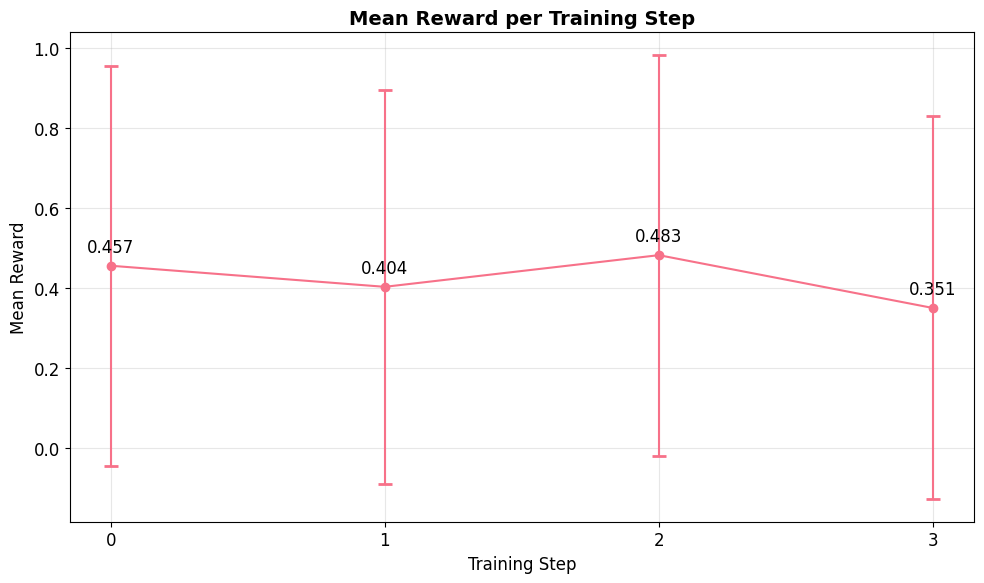


Additional statistics:
Overall mean reward: 0.420
Reward improvement from step 0 to step 3: -0.106
Tag correctness by step:
step_idx
0    0.646739
1    0.658654
2    0.715909
3    0.629808
Name: tag_correct, dtype: float64


In [3]:
# Calculate mean reward per step
reward_per_step = rollouts_df.groupby('step_idx')['reward'].agg(['mean', 'std', 'count']).reset_index()
print("Mean reward per step:")
print(reward_per_step)

# Create the plot
plt.figure(figsize=(10, 6))
plt.errorbar(reward_per_step['step_idx'], reward_per_step['mean'], 
             yerr=reward_per_step['std'], marker='o', capsize=5, capthick=2)
plt.title('Mean Reward per Training Step', fontsize=14, fontweight='bold')
plt.xlabel('Training Step')
plt.ylabel('Mean Reward')
plt.grid(True, alpha=0.3)
plt.xticks(reward_per_step['step_idx'])

# Add value labels on the points
for i, row in reward_per_step.iterrows():
    plt.annotate(f'{row["mean"]:.3f}', 
                (row['step_idx'], row['mean']), 
                textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Also show some additional statistics
print(f"\nAdditional statistics:")
print(f"Overall mean reward: {rollouts_df['reward'].mean():.3f}")
print(f"Reward improvement from step 0 to step 3: {reward_per_step.iloc[-1]['mean'] - reward_per_step.iloc[0]['mean']:.3f}")
print(f"Tag correctness by step:")
tag_correct_per_step = rollouts_df.groupby('step_idx')['tag_correct'].mean()
print(tag_correct_per_step)